In [58]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)

<module 'classification_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\classification_modules.py'>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# set configurations
sample_size = 500
nr_sample_sets = 20
num_steps = 200
x_b = np.linspace(0,1,num_steps)

n_folds = 5

### Bounded distributions

In [48]:
bounded_dists = dm.get_bounded_distribution_v2()
bounded_samples = dm.get_samples(bounded_dists, nr_sample_sets, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [49]:
kde_df = dem.get_kde(bounded_samples, x_b)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,label
0,0.435871,0.456010,0.476087,0.496043,0.515820,0.535366,0.554631,0.573571,0.592143,0.610312,...,0.796123,0.775007,0.753041,0.730280,0.706785,0.682630,0.657894,0.632664,0.607032,beta_1_1
1,0.491735,0.514883,0.537890,0.560674,0.583153,0.605250,0.626893,0.648013,0.668550,0.688447,...,0.676004,0.654969,0.633240,0.610895,0.588019,0.564701,0.541038,0.517127,0.493068,beta_1_1
2,0.387797,0.408282,0.428850,0.449435,0.469973,0.490402,0.510663,0.530701,0.550465,0.569909,...,0.738306,0.718842,0.698330,0.676847,0.654481,0.631328,0.607491,0.583081,0.558215,beta_1_1


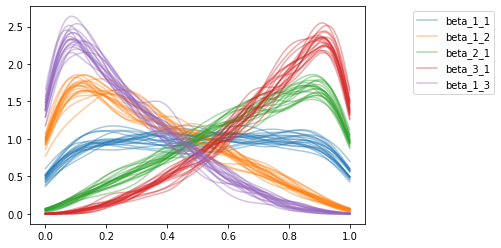

In [50]:
dem.get_kde_plot(kde_df,x_b)

In [51]:
bounded_samples_st = dm.get_st_samples(bounded_dists, nr_sample_sets, sample_size)
min_ = np.percentile(bounded_samples_st.iloc[:,:-1],2.5)
max_ = np.percentile(bounded_samples_st.iloc[:,:-1],97.5)
x_b_st = np.linspace(min_, max_, num_steps)
kde_df = dem.get_kde(bounded_samples_st, x_b_st)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,label
0,0.128288,0.134448,0.140586,0.146680,0.152712,0.158666,0.164524,0.170273,0.175898,0.181390,...,0.170940,0.162947,0.154920,0.146892,0.138900,0.130977,0.123157,0.115470,0.107948,beta_1_1
1,0.129455,0.136238,0.143021,0.149778,0.156483,0.163112,0.169640,0.176044,0.182302,0.188395,...,0.177355,0.170723,0.163949,0.157061,0.150089,0.143064,0.136015,0.128974,0.121972,beta_1_1
2,0.119286,0.125052,0.130808,0.136536,0.142218,0.147840,0.153387,0.158845,0.164204,0.169452,...,0.195569,0.189555,0.183293,0.176810,0.170135,0.163299,0.156335,0.149276,0.142155,beta_1_1


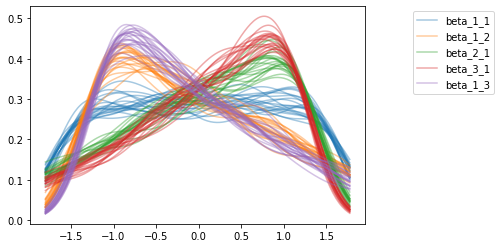

In [52]:
dem.get_kde_plot(kde_df,x_b_st)

### SVM

In [53]:
sample_size_list = [5, 10, 50, 100, 500, 1000]
num_steps_list = list(np.arange(1,21))

In [59]:
res_svm = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample_sets, n_folds, 'kde', 1)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
res_svm.to_csv('results/kde/res_svm_bounded.csv')

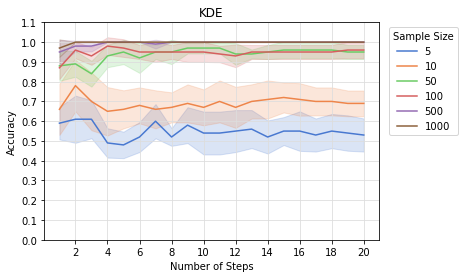

In [60]:
cm.plot_cv_numsteps_samplesize(res_svm,'KDE')

### Logistic Regression

In [16]:
res_lr = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, n_folds, 'kde', 2)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
res_lr.to_csv('results/kde/res_lr_bounded.csv')

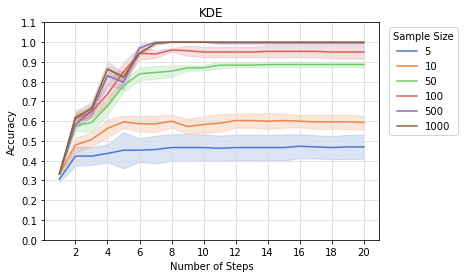

In [30]:
cm.plot_cv_numsteps_samplesize(res_lr,'KDE')

### Heavytail distributions

In [19]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples = dm.get_samples(heavytail_dists, nr_sample, sample_size, transform=True)
#dm.plot_histograms_of_samples(heavytail_samples)

In [20]:
perc_95 = np.percentile(heavytail_samples.iloc[:,:-1],95)
x_h = np.linspace(0,perc_95,num_steps)
kde_df = dem.get_kde(heavytail_samples, x_h)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.341617,0.366444,0.390977,0.414988,0.438259,0.460587,0.481788,0.501702,0.520197,0.537171,...,0.069810,0.066444,0.063253,0.060250,0.057447,0.054850,0.052456,0.050260,0.048247,cauchy
1,0.382405,0.402719,0.422977,0.443073,0.462894,0.482328,0.501260,0.519573,0.537155,0.553891,...,0.061462,0.059045,0.056722,0.054498,0.052376,0.050359,0.048450,0.046651,0.044965,cauchy
2,0.397802,0.421512,0.444604,0.466899,0.488233,0.508462,0.527466,0.545150,0.561444,0.576306,...,0.072586,0.068880,0.065112,0.061303,0.057477,0.053659,0.049877,0.046157,0.042527,cauchy


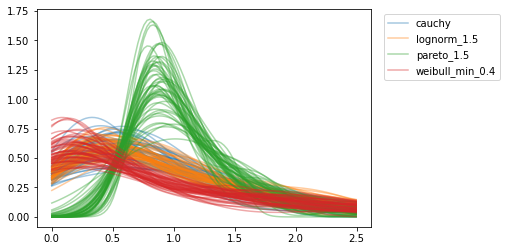

In [21]:
dem.get_kde_plot(kde_df,x_h)

### SVM

In [22]:
res_svm_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, n_folds, 'kde', 1, transform=True)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [23]:
res_svm_ht.to_csv('results/kde/res_svm_heavytail.csv')

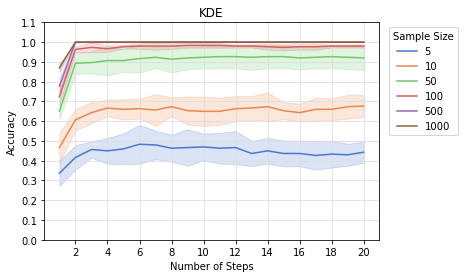

In [26]:
cm.plot_cv_numsteps_samplesize(res_svm_ht,'KDE')

### Logististic Regression

In [28]:
res_lr_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, heavytail_dists, nr_sample, n_folds, 'kde', 2, transform = True)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
res_lr_ht.to_csv('results/kde/res_lr_heavytail.csv')

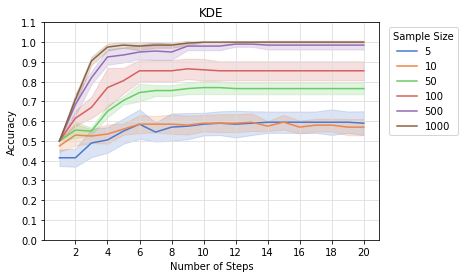

In [29]:
cm.plot_cv_numsteps_samplesize(res_lr_ht,'KDE')